# CST 407 ML - Assignment 4

## _Independent Study -- Classifying Images of "Natural" Environments_

1. Loading relevant data
2. Visualizing data
3. Pre-processing data
4. Training model
5. Visualizing results
6. Correction
7. Prediction

### 1. Load relevant data

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

datapath = os.path.join("datasets", "natural", "seg_train", "seg_train", "")
datapath = pathlib.Path(datapath)

### 2. Explore the data

In [77]:
# all images are 150 x 150
# images come from 6 distinct categories:
#     0. buildings
#     1. forest
#     2. glacier
#     3. mountain
#     4. sea
#     5. street

image_count = len(list(datapath.glob('*/*.jpg')))
print(image_count)

14034


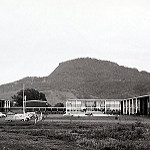

In [78]:
foo = list(datapath.glob('buildings/*'))
PIL.Image.open(str(foo[0]))

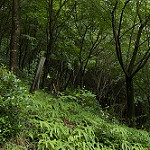

In [80]:
bar = list(datapath.glob('forest/*'))
PIL.Image.open(str(bar[0]))

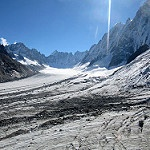

In [81]:
foo = list(datapath.glob('glacier/*'))
PIL.Image.open(str(foo[0]))

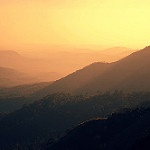

In [82]:
bar = list(datapath.glob('mountain/*'))
PIL.Image.open(str(bar[0]))

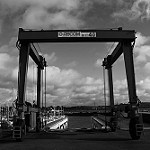

In [83]:
foo = list(datapath.glob('sea/*'))
PIL.Image.open(str(foo[0]))

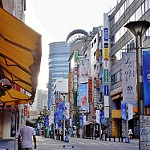

In [84]:
bar = list(datapath.glob('street/*'))
PIL.Image.open(str(bar[0]))

#### Images look good, now its time to establish the datasets as necessary to work within the neural network.

In [85]:
batch_size = 32
img_height = 150
img_width = 150

In [86]:
# here, the example code is followed strictly instead of trying
# to use the respective provided directories for training images
# versus testing images. 

# this means that only the training set of images (/seg_train/)
# is used for both training and validation

# because the size of the dataset is already so large with
# 14K images in the training set alone, no need to pile more
# work on to my poor laptop -- training the model takes a 
# long time!

# interesting sidenote: if I were to use both the training and
# testing datasets (with a computer capable of handling them), 
# the ratio ends up (roughly) at
#               14K : 3K
#     [training]  8 : 2  [validation]
# which is the same standard suggested by TensorFlow, suggesting 
# that the dataset is well constructed

train_ds = tf.keras.utils.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [87]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  datapath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [88]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### 2.5 Visualize the data

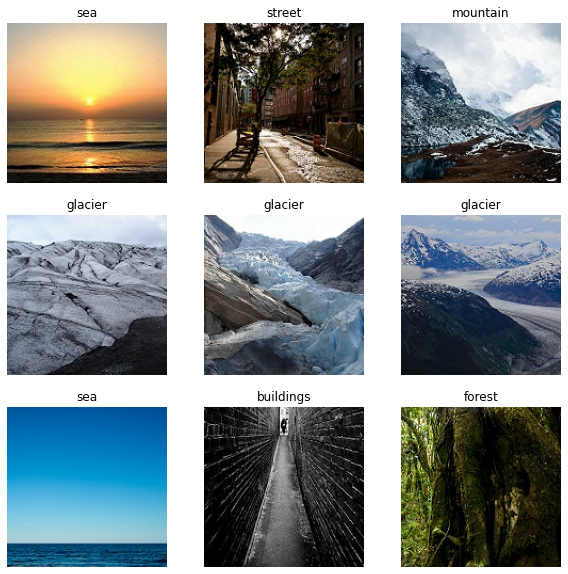

In [89]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [90]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [91]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 3. Pre-process the data

In [92]:
# because RGB channel values range from 0 to 255, these values
# must be made much smaller (normalized) to work within the
# neural network

normalization_layer = layers.Rescaling(1./255)

In [93]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) # showing pixel value range

0.0 1.0


### 4. Train the model

In [94]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [95]:
# Adam is an optimzation algorithm using stochastic gradient descent
# to reduce loss during model training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [97]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
351/351 [==============================] - 98s 279ms/step - loss: 1.0417 - accuracy: 0.5976 - val_loss: 0.7894 - val_accuracy: 0.7124
Epoch 2/10
351/351 [==============================] - 98s 279ms/step - loss: 0.7109 - accuracy: 0.7371 - val_loss: 0.6496 - val_accuracy: 0.7427
Epoch 3/10
351/351 [==============================] - 106s 301ms/step - loss: 0.5294 - accuracy: 0.8099 - val_loss: 0.5264 - val_accuracy: 0.8068
Epoch 4/10
351/351 [==============================] - 109s 312ms/step - loss: 0.3991 - accuracy: 0.8561 - val_loss: 0.5491 - val_accuracy: 0.7990
Epoch 5/10
351/351 [==============================] - 109s 310ms/step - loss: 0.2752 - accuracy: 0.9041 - val_loss: 0.6463 - val_accuracy: 0.7794
Epoch 6/10
351/351 [==============================] - 112s 319ms/step - loss: 0.1944 - accuracy: 0.9336 - val_loss: 0.7016 - val_accuracy: 0.7915
Epoch 7/10
351/351 [==============================] - 132s 376ms/step - loss: 0.1243 - accuracy: 0.9598 - val_loss: 0.7000 - v

### 5. Visualize the results

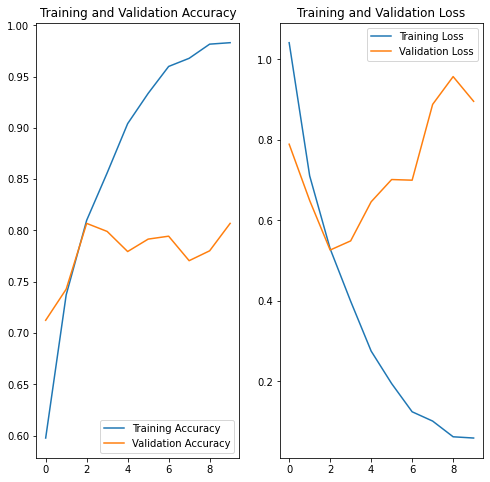

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6. Correction

In [99]:
# overfitting seen above 
# large difference between training accuracy and validation accuracy
# responding with data augmentation

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

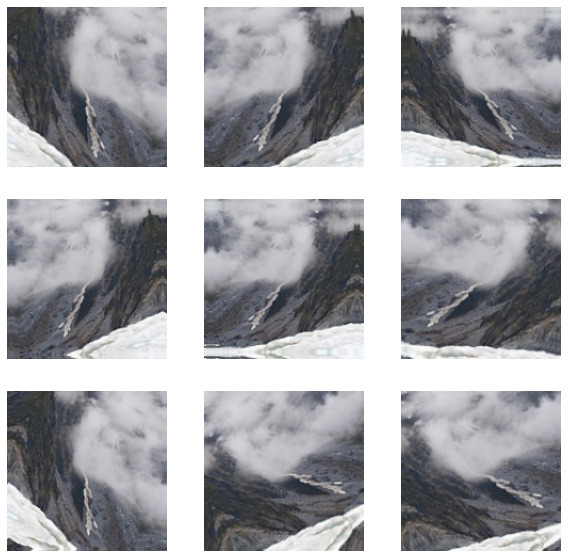

In [100]:
# testing data augmentation
# applying data augmentation to the same image several times
# as a proof of concept

# gives the network a bit more randomness and variability
# to work with in order to determine the right classs

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [101]:
# adding dropout regularization to neural network
# similar to layering seen earlier during initial model training
# now with the addition of the data augmentation layers

model = Sequential([
  data_augmentation,    # added
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),    # added
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 6.5 Retrain & Visualize

In [102]:
# same as before
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [104]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 111s 314ms/step - loss: 1.0788 - accuracy: 0.5761 - val_loss: 0.8419 - val_accuracy: 0.6850
Epoch 2/15
351/351 [==============================] - 116s 331ms/step - loss: 0.8404 - accuracy: 0.6877 - val_loss: 0.7931 - val_accuracy: 0.7010
Epoch 3/15
351/351 [==============================] - 123s 351ms/step - loss: 0.7256 - accuracy: 0.7281 - val_loss: 0.7106 - val_accuracy: 0.7541
Epoch 4/15
351/351 [==============================] - 128s 363ms/step - loss: 0.6679 - accuracy: 0.7545 - val_loss: 0.7592 - val_accuracy: 0.7267
Epoch 5/15
351/351 [==============================] - 127s 361ms/step - loss: 0.6159 - accuracy: 0.7751 - val_loss: 0.6142 - val_accuracy: 0.7751
Epoch 6/15
351/351 [==============================] - 126s 359ms/step - loss: 0.5861 - accuracy: 0.7874 - val_loss: 0.5900 - val_accuracy: 0.7894
Epoch 7/15
351/351 [==============================] - 128s 364ms/step - loss: 0.5575 - accuracy: 0.7944 - val_loss: 0.6282 -

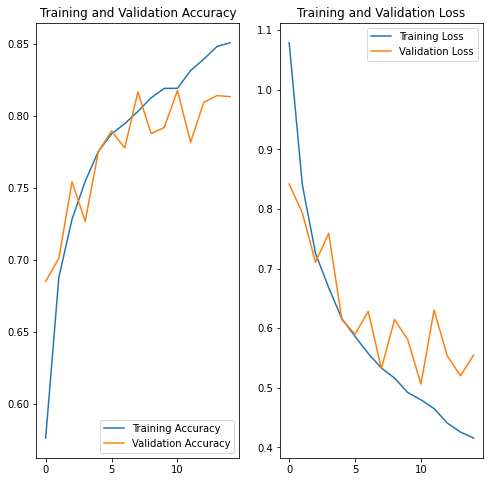

In [105]:
# 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Much less overfitting is seen here when compared to the initial model. While certainly not perfect, it is an improvement, and predictions made using this model should be more accurate than the last.

### 7. Prediction

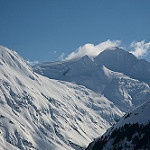

In [142]:
# setting up new path to prediction image folder
predictpath = os.path.join("datasets", "natural", "seg_pred", "")
predictpath = pathlib.Path(predictpath)

# retrieving an image (the "current" image) from the prediction directory
pred_imgs = list(predictpath.glob('*.jpg'))
current_img = pred_imgs[37]    # <-- change index to change predicted image
PIL.Image.open(str(current_img))

In [143]:
# opening image with PIL and converting to numpy array

img = PIL.Image.open(str(current_img))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to mountain with a 72.31 percent confidence.


#### Using the /seg_test/ image directory (unused thus far),  prediction accuracy could actually be measured against the known, desired image categorizations.

# DONE